# data_world.csv

Energia grupowana po regionie i czasie + informacje o regionie + informacje o sasiadach. LSTM, Dense, XGB

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
import xgboost as xgb
warnings.filterwarnings('ignore')
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)

2023-10-22 01:29:31.196355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 01:29:32.917296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../../data/new_usgs_small.csv')
df.head()

,time,longitude,latitude,depth,mag
0,1949-12-31 23:30:08.230000,-117.522000,34.191167,4.49,2.58
1,1949-12-31 07:16:07.740000,-117.650667,35.859333,0.00,2.01
2,1949-12-31 00:14:20.310000,-116.628833,32.143333,6.00,3.30
3,1949-12-30 21:27:38.960000,-118.089333,33.856167,0.25,1.83
4,1949-12-30 12:13:50.070000,-116.806333,32.113000,6.00,3.02


In [3]:
df = df[["time", "latitude", "longitude", "mag"]]

In [4]:
df["time"] = df["time"].apply(lambda x: x[:7])
df

,time,latitude,longitude,mag
0,1949-12,34.191167,-117.522000,2.58
1,1949-12,35.859333,-117.650667,2.01
2,1949-12,32.143333,-116.628833,3.30
3,1949-12,33.856167,-118.089333,1.83
4,1949-12,32.113000,-116.806333,3.02
...,...,...,...,...
4293100,2023-09,17.937167,-66.917667,2.28
4293101,2023-09,60.279600,-147.859600,2.00
4293102,2023-09,33.486000,-116.586500,0.64
4293103,2023-09,35.348667,-97.926667,0.84


In [5]:
time_cut = "1980-01"
df = df[df["time"] > time_cut]
df["energy"] = 10**(1.44*df["mag"]+5.24)
df["label"] = np.where(df["mag"] > 5, 1, 0)

In [6]:
geo_split = 5

In [7]:
df["latitude_old"] = df["latitude"]
df["longitude_old"] = df["longitude"]
df["latitude"] = df["latitude"] // geo_split * geo_split

df["longitude"] = df["longitude"] // geo_split * geo_split
df["pos"] = df["latitude"].astype(str) + "_" + df["longitude"].astype(str)

In [8]:
def filter_regions(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    tmp = []
    df_f = df[df["mag"] >= 5]
    df_agg = df_f.groupby(["pos"])["mag"].count().reset_index()
    for _, row in df_agg.iterrows():
        if row["mag"] >= threshold:
            tmp.append(row["pos"])
    df = df[df["pos"].isin(tmp)]
    return df

In [9]:
th = 8
df = filter_regions(df, th)

In [10]:
df

,time,latitude,longitude,mag,energy,label,latitude_old,longitude_old,pos
203350,1980-02,40.0,-125.0,1.37,1.632300e+07,0,40.501833,-124.158000,40.0_-125.0
203351,1980-02,35.0,-125.0,2.19,2.475141e+08,0,37.843667,-121.766500,35.0_-125.0
205898,1980-03,35.0,-125.0,2.97,3.287002e+09,0,35.391833,-120.479667,35.0_-125.0
205899,1980-03,30.0,-120.0,1.70,4.875285e+07,0,33.242333,-115.945000,30.0_-120.0
205900,1980-03,30.0,-120.0,2.10,1.836538e+08,0,33.242333,-115.946667,30.0_-120.0
...,...,...,...,...,...,...,...,...,...
4293099,2023-09,45.0,-125.0,0.58,1.189050e+06,0,46.260500,-122.060500,45.0_-125.0
4293100,2023-09,15.0,-70.0,2.28,3.335800e+08,0,17.937167,-66.917667,15.0_-70.0
4293101,2023-09,60.0,-150.0,2.00,1.318257e+08,0,60.279600,-147.859600,60.0_-150.0
4293102,2023-09,30.0,-120.0,0.64,1.450775e+06,0,33.486000,-116.586500,30.0_-120.0


In [11]:
df_agg = df.groupby(["latitude", "longitude", "time"]).agg({"latitude_old": "mean", "longitude_old": "mean", "energy": "sum", "label": "max"}).reset_index()
df_agg

,latitude,longitude,time,latitude_old,longitude_old,energy,label
0,-70.0,-180.0,1980-12,-65.7210,-175.7140,2.013724e+13,1
1,-70.0,-180.0,1983-11,-65.3920,-177.0840,1.037528e+13,1
2,-70.0,-180.0,1988-05,-65.4000,-176.4980,1.976970e+12,0
3,-70.0,-180.0,1989-01,-65.4580,-179.9930,3.908409e+13,1
4,-70.0,-180.0,1996-12,-65.7030,-175.8945,2.437649e+12,0
...,...,...,...,...,...,...,...
113130,85.0,85.0,2021-09,85.4822,86.6619,2.703958e+11,0
113131,85.0,85.0,2021-12,85.2923,88.9434,1.940886e+11,0
113132,85.0,85.0,2022-03,85.3454,89.5848,1.940886e+11,0
113133,85.0,85.0,2022-05,85.7215,87.7219,1.393157e+11,0


In [12]:
def make_ds(df_agg):
    dfs = []
    for i in df_agg["latitude"].unique():
        for j in df_agg["longitude"].unique():
            tmp = df_agg[(df_agg["latitude"] == i) & (df_agg["longitude"] == j)]
            if len(tmp) > 1:
                tmp = tmp.set_index("time")
                idx = pd.date_range(tmp.index.min(), tmp.index.max(), freq="MS").strftime('%Y-%m')
                tmp = tmp.reindex(idx, fill_value=0)
                tmp.index.name = "time"
                tmp["label"] = tmp["label"].shift(-1)
                tmp["latitude"] = i
                tmp["longitude"] = j
                # tmp["neighbor"] = 0 
                dfs.append(tmp)
    df_final = pd.concat(dfs)
    return df_final

In [13]:
df_final = make_ds(df_agg)

In [14]:
for i in df_final["latitude"].unique():
    for j in df_final["longitude"].unique():
        if not df_final[(df_final["latitude"] == i) & (df_final["longitude"] == j)].empty:
            for x in [-5, 0, 5]:
                for y in [-5, 0, 5]:
                    if not df_final[(df_final["latitude"] == i + x) & (df_final["longitude"] == j + y)].empty and not (x == 0 and y == 0):
                        df_final.loc[(df_final["latitude"] == i) & (df_final["longitude"] == j), "energy"] += df_final[(df_final["latitude"] == i + x) & (df_final["longitude"] == j + y)]["energy"]
                        df_final["energy"] = df_final["energy"].fillna(0)

In [15]:
block_size = 24
dfs_train, dfs_val = [], []
df_final["energy0"] = np.log(df_final["energy"] + 1)
# df_final["neighbor0"] = np.log(df_final["neighbor"] + 1)
# scaler = StandardScaler()
# scaler.fit(df_final[(df_final.index < "2016-01")]["energy0"].values.reshape(-1, 1))
# df_final["energy0"] = scaler.transform(df_final["energy0"].values.reshape(-1, 1))
# scaler.fit(df_final[(df_final.index < "2016-01")]["neighbor0"].values.reshape(-1, 1))
# df_final["neighbor0"] = scaler.transform(df_final["neighbor0"].values.reshape(-1, 1))

for i in df_final["latitude"].unique():
    for j in df_final["longitude"].unique():
        tmp = df_final[(df_final["latitude"] == i) & (df_final["longitude"] == j)]
        if len(tmp) > 1:
            scaler = MinMaxScaler()
            scaler.fit(tmp[(tmp.index < "2016-01")]["energy0"].values.reshape(-1, 1))
            tmp["energy0"] = scaler.transform(tmp["energy0"].values.reshape(-1, 1))
            # scaler.fit(tmp[(tmp.index < "2016-01")]["neighbor0"].values.reshape(-1, 1))
            # tmp["neighbor0"] = scaler.transform(tmp["neighbor0"].values.reshape(-1, 1))
            for idx in range(block_size):
                if idx != 0:
                    tmp["energy" + str(idx)] = tmp["energy0"].shift(idx)
                    # tmp["neighbor" + str(idx)] = tmp["neighbor0"].shift(idx)
                tmp["latitude" + str(idx)] = tmp["latitude_old"].shift(idx)
                tmp["longitude" + str(idx)] = tmp["longitude_old"].shift(idx)
            tmp1 = tmp[tmp.index < "2016-01"]
            tmp2 = tmp[tmp.index >= "2016-01"]
            dfs_train.append(tmp1)
            dfs_val.append(tmp2)
df_final_train = pd.concat(dfs_train)
df_final_val = pd.concat(dfs_val)

In [16]:
df_final_train

,latitude,longitude,latitude_old,longitude_old,energy,label,energy0,latitude0,longitude0,energy1,...,longitude20,energy21,latitude21,longitude21,energy22,latitude22,longitude22,energy23,latitude23,longitude23
time,,,,,,,,,,,,,,,,,,,,,
1980-12,-70.0,-180.0,-65.721,-175.714,2.013724e+13,0.0,0.938990,-65.721,-175.714,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01,-70.0,-180.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.938990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-02,-70.0,-180.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-03,-70.0,-180.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04,-70.0,-180.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08,85.0,85.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.000000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-09,85.0,85.0,0.000,0.000,0.000000e+00,0.0,0.000000,0.000,0.000,0.000000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10,85.0,85.0,0.000,0.000,1.940886e+11,0.0,0.792162,0.000,0.000,0.000000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

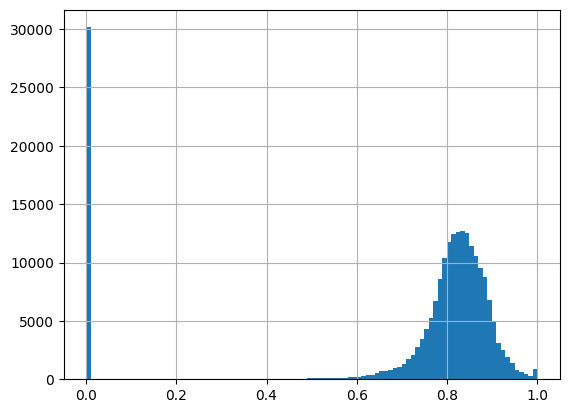

In [17]:
df_final_train["energy0"].hist(bins=100)

In [18]:
df_final_train.dropna(inplace=True)
df_final_val.dropna(inplace=True)

In [209]:
# # oversample the df_final_train until the ratio of 1 and 0 is 1:1
# df_final_train_0 = df_final_train[df_final_train["label"] == 0]
# df_final_train_1 = df_final_train[df_final_train["label"] == 1]
# df_final_train_1 = df_final_train_1.sample(len(df_final_train_0), replace=True, random_state=SEED)
# df_final_train = pd.concat([df_final_train_0, df_final_train_1])

In [210]:
# del df_final_train_0, df_final_train_1

In [211]:
df_final_train["label"].value_counts()

label
0.0    174626
1.0     24010
Name: count, dtype: int64

In [19]:
x_train = df_final_train.drop(["label", "longitude", "latitude", "energy","longitude_old", "latitude_old"], axis=1)
x_train = x_train.iloc[:, ::-1].to_numpy()
y_train = df_final_train["label"].to_numpy()
x_val = df_final_val.drop(["label", "longitude", "latitude", "energy", "longitude_old", "latitude_old"], axis=1)
x_val = x_val.iloc[:, ::-1].to_numpy()
y_val = df_final_val["label"].to_numpy()

In [20]:
# calculate balance of classes
unique, counts = np.unique(y_train, return_counts=True)
counts[0] / len(y_train)

0.8791256368432712

In [21]:
x_train = x_train.reshape(-1, block_size, 3)
x_val = x_val.reshape(-1, block_size, 3)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [22]:
# add anoother column whith 1 - label
y_train = np.concatenate((y_train, 1 - y_train), axis=1)
y_val = np.concatenate((y_val, 1 - y_val), axis=1)

In [23]:
x_pos_train = df_final_train[["longitude", "latitude"]].to_numpy()
x_pos_val = df_final_val[["longitude", "latitude"]].to_numpy()

In [24]:
class MyModel(tf.keras.Model):
    def __init__(self, n_embed):
        super(MyModel, self).__init__()
        self.n_embed = n_embed
        self.conc = tf.keras.layers.Concatenate()
        self.dense_h = tf.keras.layers.Dense(2 * n_embed)
        self.dense_c = tf.keras.layers.Dense(2 * n_embed)
        self.lstm1 = tf.keras.layers.LSTM(n_embed * 2, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(n_embed * 2)
        self.dense = tf.keras.layers.Dense(n_embed, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.out = tf.keras.layers.Dense(2)
        

    def call(self, inputs):
        loc, timestep = inputs
        h = self.dense_h(loc)
        c = self.dense_c(loc)
        x = self.lstm1(timestep, initial_state=[c, h])
        x = self.lstm2(x, initial_state=[c, h])
        x = self.dense(x)
        x = self.dropout(x)
        return self.out(x)

In [25]:
n_embed = 256
vocab_size = 2000
model = MyModel(n_embed)

2023-10-22 01:30:47.390178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 01:30:47.471663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 01:30:47.472157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 01:30:47.480559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 01:30:47.480727: I tensorflow/compile

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', tf.keras.metrics.F1Score()])

In [27]:
model.fit([x_pos_train, x_train], y_train, epochs=20, batch_size=1024, validation_data=([x_pos_val, x_val], y_val))

Epoch 1/20


2023-10-22 01:30:58.915520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/majkel/miniconda3/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2023-10-22 01:30:59.756359: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5cc114f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 01:30:59.756427: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-10-22 01:30:59.832153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 01:31:00.353633: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

194/194 [==============================] - 42s 162ms/step - loss: 0.2998 - accuracy: 0.8868 - f1_score: 0.6253 - val_loss: 0.2910 - val_accuracy: 0.8913 - val_f1_score: 0.5747
Epoch 2/20
194/194 [==============================] - 31s 162ms/step - loss: 0.2898 - accuracy: 0.8917 - f1_score: 0.6361 - val_loss: 0.2957 - val_accuracy: 0.8913 - val_f1_score: 0.5834
Epoch 3/20
194/194 [==============================] - 34s 176ms/step - loss: 0.2884 - accuracy: 0.8909 - f1_score: 0.6333 - val_loss: 0.2891 - val_accuracy: 0.8893 - val_f1_score: 0.5921
Epoch 4/20
194/194 [==============================] - 36s 188ms/step - loss: 0.2872 - accuracy: 0.8913 - f1_score: 0.6366 - val_loss: 0.2890 - val_accuracy: 0.8912 - val_f1_score: 0.5710
Epoch 5/20
153/194 [======================>.......] - ETA: 7s - loss: 0.2867 - accuracy: 0.8918 - f1_score: 0.6341

KeyboardInterrupt: 

In [117]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding="same", input_shape=(block_size, 4)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2),
])

In [119]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', tf.keras.metrics.F1Score()])

In [120]:
model.fit(x_train, y_train, epochs=20, batch_size=1024, validation_data=(x_val, y_val))

Epoch 1/20
171/171 [==============================] - 7s 24ms/step - loss: 0.5275 - accuracy: 0.8723 - f1_score: 0.6177 - val_loss: 0.3030 - val_accuracy: 0.8840 - val_f1_score: 0.6318
Epoch 2/20
171/171 [==============================] - 3s 20ms/step - loss: 0.2934 - accuracy: 0.8894 - f1_score: 0.6455 - val_loss: 0.2941 - val_accuracy: 0.8917 - val_f1_score: 0.5691
Epoch 3/20
171/171 [==============================] - 3s 20ms/step - loss: 0.2886 - accuracy: 0.8903 - f1_score: 0.6479 - val_loss: 0.2946 - val_accuracy: 0.8878 - val_f1_score: 0.6359
Epoch 4/20
171/171 [==============================] - 3s 19ms/step - loss: 0.2866 - accuracy: 0.8909 - f1_score: 0.6536 - val_loss: 0.2924 - val_accuracy: 0.8908 - val_f1_score: 0.5581
Epoch 5/20
171/171 [==============================] - 3s 20ms/step - loss: 0.2844 - accuracy: 0.8913 - f1_score: 0.6532 - val_loss: 0.2927 - val_accuracy: 0.8901 - val_f1_score: 0.6179
Epoch 6/20
171/171 [==============================] - 3s 19ms/step - loss: 

In [168]:
x_train = df_final_train.drop(["label", "energy"], axis=1).to_numpy()
y_train = df_final_train["label"].to_numpy()
x_val = df_final_val.drop(["label", "energy"], axis=1).to_numpy()
y_val = df_final_val["label"].to_numpy()

In [169]:
model = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.01, n_jobs=-1)

In [170]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='logloss', early_stopping_rounds=10)

[0]	validation_0-logloss:0.68624
[1]	validation_0-logloss:0.67951
[2]	validation_0-logloss:0.67290
[3]	validation_0-logloss:0.66642
[4]	validation_0-logloss:0.66005
[5]	validation_0-logloss:0.65382
[6]	validation_0-logloss:0.64769
[7]	validation_0-logloss:0.64167
[8]	validation_0-logloss:0.63576
[9]	validation_0-logloss:0.62997
[10]	validation_0-logloss:0.62427
[11]	validation_0-logloss:0.61870
[12]	validation_0-logloss:0.61321
[13]	validation_0-logloss:0.60781
[14]	validation_0-logloss:0.60252
[15]	validation_0-logloss:0.59730
[16]	validation_0-logloss:0.59220
[17]	validation_0-logloss:0.58717
[18]	validation_0-logloss:0.58222
[19]	validation_0-logloss:0.57740
[20]	validation_0-logloss:0.57263
[21]	validation_0-logloss:0.56793
[22]	validation_0-logloss:0.56329
[23]	validation_0-logloss:0.55871
[24]	validation_0-logloss:0.55423
[25]	validation_0-logloss:0.54980
[26]	validation_0-logloss:0.54549
[27]	validation_0-logloss:0.54126
[28]	validation_0-logloss:0.53705
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [171]:
y_pred = model.predict(x_val)
accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)

(0.9064726515400636, 0.5715003138731952)